In [178]:
#Import
import pandas as pd
import numpy as np

#Data
import pickle

#Utilities
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

#Models
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score, cross_validate

In [202]:
df = pd.read_excel("../qspr/DIPPR.xlsx", sheet_name=0)

In [203]:
# Parameters
radius = 2           # Typical radius for ECFP4
n_bits = 2048        # Length of the fingerprint vector

# Convert SMILES to RDKit Mol objects
df['Mol'] = df['SMILE'].apply(Chem.MolFromSmiles)

# Drop invalid molecules
df = df[df['Mol'].notnull()].copy()

# Function to compute Morgan fingerprint as numpy array
def morgan_fp(mol, radius=2, nBits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((1,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply and convert to a DataFrame
fp_array = df['Mol'].apply(lambda mol: morgan_fp(mol, radius, n_bits))
fp_df = pd.DataFrame(fp_array.tolist(), index=df.index)
fp_df.columns = [f'FP_{i}' for i in range(n_bits)]

# Merge with original dataframe
df = pd.concat([df, fp_df], axis=1)

[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerator
[15:21:44] DEPRECATION WARNING: please use MorganGenerat

In [204]:
# Assuming your Morgan fingerprint columns are all the 'FP_' prefixed columns
fp_cols = [col for col in df.columns if col.startswith('FP_')]

# Select only those columns
fp_data = df[fp_cols]

# Find columns where all values are identical
cols_to_drop = [col for col in fp_cols if fp_data[col].nunique() == 1]

# Drop those columns from the dataframe
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} constant columns.")


Dropped 1661 constant columns.


In [ ]:
# def select_diverse_t(group, n=5):
#     if len(group) <= n:
#         return group  # keep all if fewer than n
    
#     # Sort by 'T'
#     group_sorted = group.sort_values('T').reset_index(drop=True)
    
#     # Choose indices to maximize spread — pick 5 points evenly spaced along sorted T
#     indices = np.linspace(0, len(group_sorted) - 1, n).round().astype(int)
    
#     return group_sorted.loc[indices]

# # Apply grouping by 'SMILE' and select diverse rows
# df_filtered = df.groupby('SMILE').apply(select_diverse_t).reset_index(drop=True)

# print(df_filtered)

In [205]:
unique_smiles = df['SMILE'].unique()
smiles_train, smiles_test = train_test_split(unique_smiles, test_size=0.2, random_state=42)

In [ ]:
# # 3. Function to check if all families are in training
# def all_families_in_train(smiles_train, df):
#     families_train = set(df[df['SMILE'].isin(smiles_train)]['Family'].unique())
#     all_families = set(df['Family'].unique())
#     return all_families.issubset(families_train)

# # 4. Adjust training set to include all families
# if not all_families_in_train(smiles_train, df):
#     # Find which families are missing in training
#     families_train = set(df[df['SMILE'].isin(smiles_train)]['Family'].unique())
#     all_families = set(df['Family'].unique())
#     missing_families = all_families - families_train

#     # For each missing family, find SMILES in test set and move them to train
#     for family in missing_families:
#         # SMILES of that family in test set
#         smiles_to_add = df[(df['Family'] == family) & (df['SMILE'].isin(smiles_test))]['SMILE'].unique()
#         # Add these SMILES to train set
#         for s in smiles_to_add:
#             smiles_train = list(smiles_train)
#             smiles_test = list(smiles_test)
#             if s in smiles_test:
#                 smiles_test.remove(s)
#                 smiles_train.append(s)
#             smiles_train = np.array(smiles_train)
#             smiles_test = np.array(smiles_test)

In [206]:
train_df = df[df['SMILE'].isin(smiles_train)]
test_df = df[df['SMILE'].isin(smiles_test)]

In [207]:
smiles_counts = train_df['SMILE'].value_counts()

# Map each sample to 1 / count of its SMILES
weights = train_df['SMILE'].map(lambda s: 1.0 / smiles_counts[s])

In [208]:
X_train = train_df.drop(columns=['Name', 'SMILE', 'CAS', 'Family', 'K', 'Mol'])
y_train = train_df['K']

X_test = test_df.drop(columns=['Name', 'SMILE', 'CAS', 'Family', 'K', 'Mol'])
y_test = test_df['K']

In [213]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,            # Try reducing depth
    learning_rate=0.05,     # Lower learning rate
    n_estimators=500,       # More trees to compensate for lower learning rate
    subsample=0.7,          # Randomly sample rows
    colsample_bytree=0.7,   # Randomly sample columns
    reg_alpha=1,            # L1 regularization
    reg_lambda=1,           # L2 regularization
    random_state=42,
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [214]:
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Root Mean Squared Error: 0.0428
R² Score: -2.9421


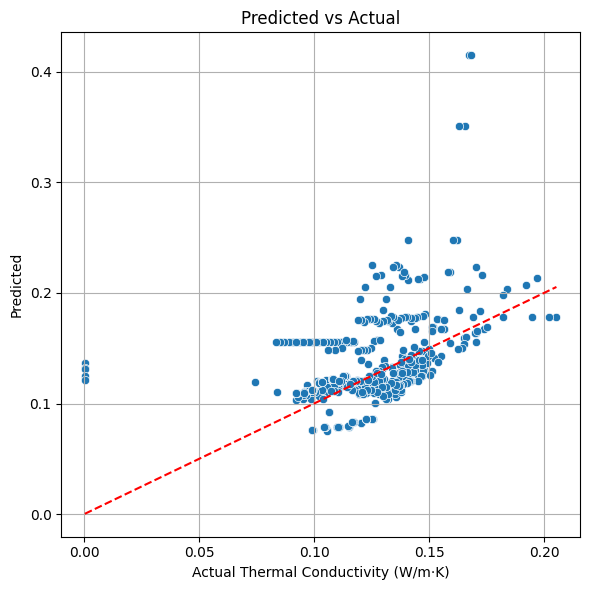

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prediction vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Thermal Conductivity (W/m·K)")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [127]:
# Define groups based on SMILES to prevent leakage
groups = train_df['SMILE']

# Setup GroupKFold
gkf = GroupKFold(n_splits=5)

# Evaluate with cross_val_score using R^2 (or you can use neg_root_mean_squared_error)
cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=gkf.split(X_train, y_train, groups),
    scoring='r2'  # or 'neg_root_mean_squared_error'
)

print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R² score: {np.mean(cv_scores):.4f}")

Cross-validated R² scores: [-7.60361795e-02 -1.87899790e+03 -1.52413515e+03  1.29686054e-01
 -7.76669708e-02]
Mean R² score: -680.6314


In [67]:
cv_results = cross_validate(
    model, X_train, y_train,
    cv=gkf.split(X_train, y_train, groups),
    scoring={'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'},
    return_train_score=True
)

print("Cross-validation results:")
print(f"Mean Train R²: {np.mean(cv_results['train_r2']):.4f}")
print(f"Mean Test R²: {np.mean(cv_results['test_r2']):.4f}")
print(f"Mean Test RMSE: {-np.mean(cv_results['test_rmse']):.4f}")

Cross-validation results:
Mean Train R²: 0.9969
Mean Test R²: -0.5936
Mean Test RMSE: 0.6457


In [162]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
model.fit(X_train, y_train, sample_weight=weights)

RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

In [163]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.0008
R² Score: 0.1600


In [164]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
model = Ridge(alpha=1.0)  # Try Lasso or ElasticNet similarly
model.fit(X_train, y_train, sample_weight=weights)

Ridge()

In [165]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.0568
R² Score: -61.2777


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

In [ ]:
# Initialize the model
et_model = ExtraTreesRegressor(
    n_estimators=200,      
    max_depth=10,
    min_samples_split=5,   
    random_state=42,
    n_jobs=-1            
)

# Train it
et_model.fit(X_train, y_train, sample_weight=weights)

# Predict
y_pred = et_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"ExtraTrees R²: {r2:.4f}")
print(f"ExtraTrees RMSE: {rmse:.4f}")


ExtraTrees R²: 0.5709
ExtraTrees RMSE: 0.0198


In [170]:
gkf = GroupKFold(n_splits=10)
groups = train_df['SMILE']

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    et_model, X_train, y_train,
    cv=gkf.split(X_train, y_train, groups),
    scoring='r2'
)

print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {np.mean(cv_scores):.4f}")

Cross-validated R² scores: [-6.65672890e+02  8.36154166e-02 -3.15999952e+01 -1.33215387e-01
  7.77988453e-01  3.75249010e-01 -1.49180822e-01 -1.81977351e-01
  5.40252974e-01  4.09715336e-01]
Mean CV R²: -69.5550


In [221]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Step 1: Initialize the SVR model with your chosen kernel
svr = SVR(kernel='rbf')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Fit the model on training data
svr.fit(X_train_scaled, y_train)

# Step 3: Predict on test data
y_pred = svr.predict(X_test_scaled)

# Step 4: Evaluate the model
mse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 0.0985
R2 Score: -19.9065


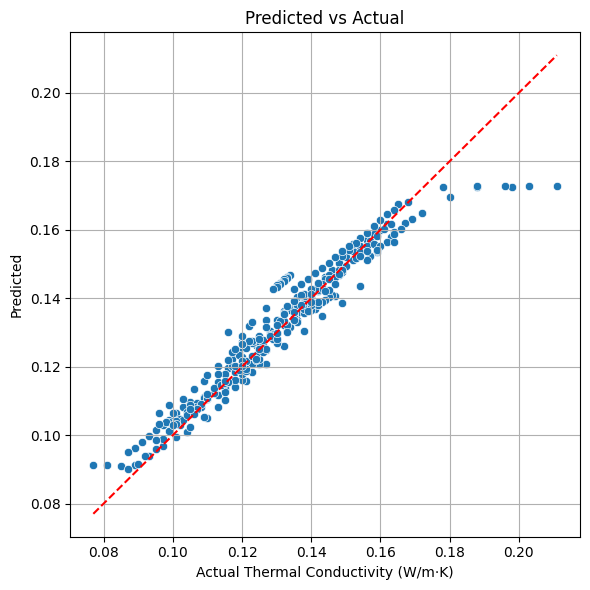

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prediction vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Thermal Conductivity (W/m·K)")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

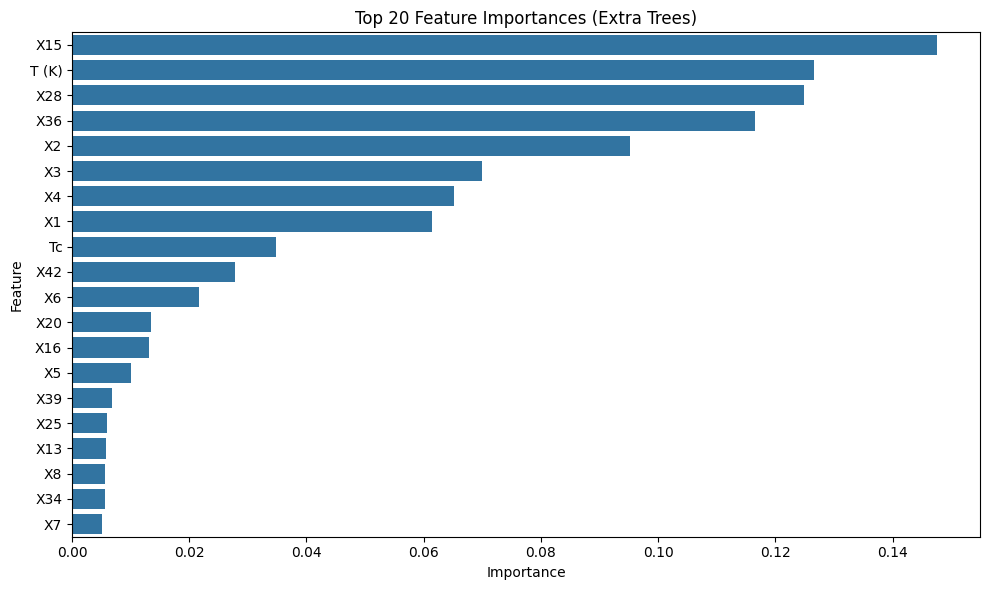

In [25]:
importances = et_model.feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot top N
top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:top_n], y=feat_imp.index[:top_n])
plt.title(f"Top {top_n} Feature Importances (Extra Trees)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [42]:
train_list = train_df['SMILES'].tolist()
test_list = test_df['SMILES'].tolist()

[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerator
[11:50:29] DEPRECATION WARNING: please use MorganGenerat

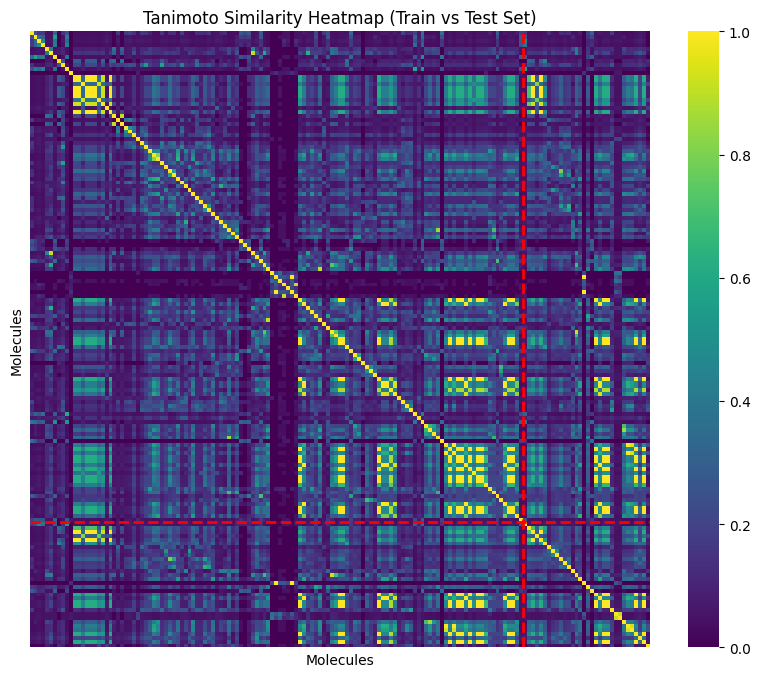

In [48]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Your lists of SMILES from the train and test sets
train_list = train_df['SMILES'].tolist()
test_list = test_df['SMILES'].tolist()

# Combine both lists to calculate similarities between all molecules
combined_list = train_list + test_list

# Step 1: Generate RDKit molecules and fingerprints for combined list
mols = [Chem.MolFromSmiles(sm) for sm in combined_list]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols]

# Step 2: Compute Tanimoto similarity matrix between all pairs
n = len(fps)
similarity_matrix = np.zeros((n, n))
for i in range(n):
    similarities = BulkTanimotoSimilarity(fps[i], fps)
    similarity_matrix[i, :] = similarities

# Step 3: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)

# Add labels and title
plt.title("Tanimoto Similarity Heatmap (Train vs Test Set)")
plt.xlabel("Molecules")
plt.ylabel("Molecules")

# Highlight the border between training and test sets
plt.axvline(x=len(train_list), color='red', linestyle='--', lw=2)
plt.axhline(y=len(train_list), color='red', linestyle='--', lw=2)

plt.show()

SCAFFOLD SPLITTING

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import train_test_split
import numpy as np

In [107]:
df_new = df[['Name', 'SMILES', 'Tc', 'Tau', 'T (K)', 'l (W.m-1.K-1)']].copy()

In [108]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# List of all RDKit descriptors
descriptor_list = [desc[0] for desc in Descriptors._descList]

def generate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(descriptor_list)
    return [desc_func(mol) for desc_name, desc_func in Descriptors._descList]

def featurize_dataframe(df, smiles_column='SMILES'):
    features = df[smiles_column].apply(generate_descriptors)
    feature_df = pd.DataFrame(features.tolist(), columns=descriptor_list)
    return pd.concat([df.reset_index(drop=True), feature_df], axis=1)

# Apply to your splits
df_feats = featurize_dataframe(df_new, smiles_column='SMILES')

In [109]:
def drop_constant_columns(df, exclude_columns=['smiles', 'label']):
    # Identify columns to check (ignore smiles, label, etc.)
    cols_to_check = [col for col in df.columns if col not in exclude_columns]
    
    # Find columns where all values are the same
    constant_cols = [col for col in cols_to_check if df[col].nunique() <= 1]
    
    # Drop them
    df_clean = df.drop(columns=constant_cols)
    
    print(f"Dropped {len(constant_cols)} constant columns.")
    return df_clean

# Example:
df_feats = drop_constant_columns(df_feats)

Dropped 76 constant columns.


In [122]:
def get_murcko_scaffold(smiles, include_chirality=False):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)
    return scaffold

def scaffold_split(df, smiles_column='SMILES', frac_train=0.8, random_state=42):
    # Get the scaffolds
    scaffolds = {}
    for idx, smiles in df[smiles_column].items():
        scaffold = get_murcko_scaffold(smiles)
        if scaffold is not None:
            scaffolds.setdefault(scaffold, []).append(idx)

    # Shuffle scaffolds
    np.random.seed(random_state)
    scaffold_sets = list(scaffolds.values())
    np.random.shuffle(scaffold_sets)

    train_idx = []
    test_idx = []

    n_total = len(df)
    n_train = int(frac_train * n_total)

    for scaffold_set in scaffold_sets:
        if len(train_idx) + len(scaffold_set) <= n_train:
            train_idx.extend(scaffold_set)
        else:
            test_idx.extend(scaffold_set)

    train_df = df.loc[train_idx].reset_index(drop=True)
    test_df = df.loc[test_idx].reset_index(drop=True)

    return train_df, test_df

test_df, train_df = scaffold_split(df_feats)

In [132]:
df_feats

,Name,SMILES,Tc,Tau,T (K),l (W.m-1.K-1),MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,fr_ester,fr_ether,fr_furan,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
0,(1-methylethyl)benzene,CC(C)c1ccccc1,631.0,0.53,298.0,0.125,2.203704,2.203704,0.658519,0.658519,...,0,0,0,0,0,0,0,0,0,0
1,(1-methylethyl)benzene,CC(C)c1ccccc1,631.0,0.51,310.8,0.122,2.203704,2.203704,0.658519,0.658519,...,0,0,0,0,0,0,0,0,0,0
2,(1-methylethyl)benzene,CC(C)c1ccccc1,631.0,0.49,323.6,0.119,2.203704,2.203704,0.658519,0.658519,...,0,0,0,0,0,0,0,0,0,0
3,(1-methylethyl)benzene,CC(C)c1ccccc1,631.0,0.47,336.3,0.116,2.203704,2.203704,0.658519,0.658519,...,0,0,0,0,0,0,0,0,0,0
4,(1-methylethyl)benzene,CC(C)c1ccccc1,631.0,0.45,349.1,0.113,2.203704,2.203704,0.658519,0.658519,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,"2,5-dimethylfuran",Cc1ccc(C)o1,558.6,0.34,366.8,0.099,5.083333,5.083333,0.983796,0.983796,...,0,0,1,0,0,0,0,0,0,0
1566,"2,5-dimethylfuran",Cc1ccc(C)o1,558.6,0.34,371.3,0.098,5.083333,5.083333,0.983796,0.983796,...,0,0,1,0,0,0,0,0,0,0
1567,"2,5-dimethylfuran",Cc1ccc(C)o1,558.6,0.33,375.7,0.097,5.083333,5.083333,0.983796,0.983796,...,0,0,1,0,0,0,0,0,0,0
1568,"2,5-dimethylfuran",Cc1ccc(C)o1,558.6,0.32,380.2,0.096,5.083333,5.083333,0.983796,0.983796,...,0,0,1,0,0,0,0,0,0,0


In [123]:
train_df

,Name,SMILES,Tc,Tau,T (K),l (W.m-1.K-1),MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,fr_ester,fr_ether,fr_furan,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
0,"1,2-bis(2-methoxyethoxy)ethane",COCCOCCOCCOC,651.0,0.53,308.2,0.164,5.163438,5.163438,0.618129,0.618129,...,0,4,0,0,0,2,0,0,0,0
1,"1,2-bis(2-methoxyethoxy)ethane",COCCOCCOCCOC,651.0,0.52,312.6,0.162,5.163438,5.163438,0.618129,0.618129,...,0,4,0,0,0,2,0,0,0,0
2,"1,2-bis(2-methoxyethoxy)ethane",COCCOCCOCCOC,651.0,0.51,317.0,0.160,5.163438,5.163438,0.618129,0.618129,...,0,4,0,0,0,2,0,0,0,0
3,"1,2-bis(2-methoxyethoxy)ethane",COCCOCCOCCOC,651.0,0.51,321.5,0.158,5.163438,5.163438,0.618129,0.618129,...,0,4,0,0,0,2,0,0,0,0
4,"1,2-bis(2-methoxyethoxy)ethane",COCCOCCOCCOC,651.0,0.50,325.9,0.156,5.163438,5.163438,0.618129,0.618129,...,0,4,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,vinylacetate,C=CCC([O])=O,519.2,0.38,320.6,0.143,9.416944,9.416944,0.055556,-1.078704,...,0,0,0,0,0,0,0,0,0,0
1236,vinylacetate,C=CCC([O])=O,519.2,0.37,325.5,0.141,9.416944,9.416944,0.055556,-1.078704,...,0,0,0,0,0,0,0,0,0,0
1237,vinylacetate,C=CCC([O])=O,519.2,0.36,330.4,0.139,9.416944,9.416944,0.055556,-1.078704,...,0,0,0,0,0,0,0,0,0,0
1238,vinylacetate,C=CCC([O])=O,519.2,0.35,335.3,0.137,9.416944,9.416944,0.055556,-1.078704,...,0,0,0,0,0,0,0,0,0,0


In [124]:
test_df

,Name,SMILES,Tc,Tau,T (K),l (W.m-1.K-1),MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,...,fr_ester,fr_ether,fr_furan,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_unbrch_alkane
0,cyclopentane,C1CCCC1,511.7,0.54,234.7,0.151,1.500000,1.500000,1.50000,1.50000,...,0,0,0,0,0,0,0,0,0,0
1,cyclopentane,C1CCCC1,511.7,0.53,242.9,0.148,1.500000,1.500000,1.50000,1.50000,...,0,0,0,0,0,0,0,0,0,0
2,cyclopentane,C1CCCC1,511.7,0.51,251.1,0.145,1.500000,1.500000,1.50000,1.50000,...,0,0,0,0,0,0,0,0,0,0
3,cyclopentane,C1CCCC1,511.7,0.49,259.2,0.142,1.500000,1.500000,1.50000,1.50000,...,0,0,0,0,0,0,0,0,0,0
4,cyclopentane,C1CCCC1,511.7,0.48,267.4,0.139,1.500000,1.500000,1.50000,1.50000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,cyclohexanone,O=C1CCCCC1,665.0,0.48,342.6,0.133,10.463056,10.463056,0.46412,0.46412,...,0,0,0,1,1,0,0,0,0,0
326,cyclohexanone,O=C1CCCCC1,665.0,0.46,356.5,0.132,10.463056,10.463056,0.46412,0.46412,...,0,0,0,1,1,0,0,0,0,0
327,cyclohexanone,O=C1CCCCC1,665.0,0.44,370.4,0.130,10.463056,10.463056,0.46412,0.46412,...,0,0,0,1,1,0,0,0,0,0
328,cyclohexanone,O=C1CCCCC1,665.0,0.42,384.3,0.128,10.463056,10.463056,0.46412,0.46412,...,0,0,0,1,1,0,0,0,0,0


In [125]:
X_train = train_df.drop(columns=['l (W.m-1.K-1)', 'Name', 'SMILES'])
y_train = train_df['l (W.m-1.K-1)']
X_test = test_df.drop(columns=['l (W.m-1.K-1)', 'Name', 'SMILES'])
y_test = test_df['l (W.m-1.K-1)']

In [130]:
# Initialize the model
et_model = ExtraTreesRegressor(
    n_estimators=100,      # Number of trees
    max_depth=None,        # Or try something like 10
    min_samples_split=5,   # Try increasing to 5+ to reduce overfitting
    random_state=42,         
)

# Train it
et_model.fit(X_train, y_train)

# Predict
y_pred = et_model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"ExtraTrees R²: {r2:.4f}")
print(f"ExtraTrees RMSE: {rmse:.4f}")

ExtraTrees R²: -0.1230
ExtraTrees RMSE: 0.0003


In [129]:
gkf = GroupKFold(n_splits=10)
groups = train_df['SMILES']

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    et_model, X_train, y_train,
    cv=gkf.split(X_train, y_train, groups),
    scoring='r2'
)

print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {np.mean(cv_scores):.4f}")

Cross-validated R² scores: [0.92536805 0.93713656 0.64214775 0.71601831 0.89673769 0.89140432
 0.08440379 0.84956681 0.90784292 0.90341981]
Mean CV R²: 0.7754


[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerator
[13:44:42] DEPRECATION WARNING: please use MorganGenerat

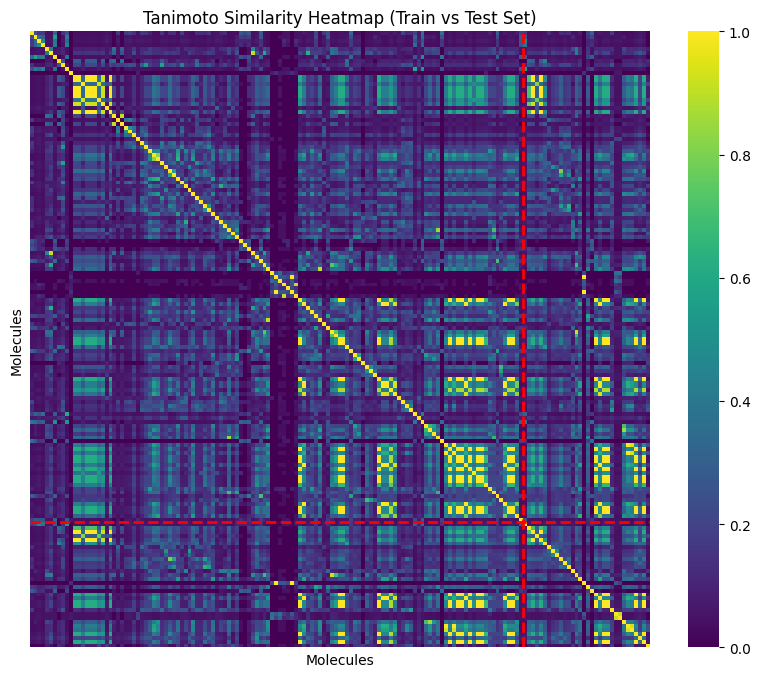

In [131]:
# Combine both lists to calculate similarities between all molecules
combined_list = train_list + test_list

# Step 1: Generate RDKit molecules and fingerprints for combined list
mols = [Chem.MolFromSmiles(sm) for sm in combined_list]
fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols]

# Step 2: Compute Tanimoto similarity matrix between all pairs
n = len(fps)
similarity_matrix = np.zeros((n, n))
for i in range(n):
    similarities = BulkTanimotoSimilarity(fps[i], fps)
    similarity_matrix[i, :] = similarities

# Step 3: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)

# Add labels and title
plt.title("Tanimoto Similarity Heatmap (Train vs Test Set)")
plt.xlabel("Molecules")
plt.ylabel("Molecules")

# Highlight the border between training and test sets
plt.axvline(x=len(train_list), color='red', linestyle='--', lw=2)
plt.axhline(y=len(train_list), color='red', linestyle='--', lw=2)

CHECK DIFFERENCES BETWEEN QSPR DATASET AND THERMO DATASET (SDB1)

In [134]:
def load_pickle_file(filename):
    """Load a pickle file and return its contents."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load the data
thermo_df = load_pickle_file('../cleaned_df_original.pkl')

In [135]:
thermo_df

,compA,compB,XA,XB,T,P,K,mA,mB,CAS_A,CAS_B,SMILES_A,SMILES_B,MW_A,MW_B,KA,KB
0,"1,1'-oxybis(2-methoxyethane)",dodecane,0.000,1.000,298.15,101325.0,0.136,0.000000,1.000000,111-96-6,112-40-3,COCCOCCOC,CCCCCCCCCCCC,134.1748,170.3374,0.1538,0.1360
1,"1,1'-oxybis(2-methoxyethane)",dodecane,0.093,0.907,298.15,101325.0,0.1363,0.074732,0.925268,111-96-6,112-40-3,COCCOCCOC,CCCCCCCCCCCC,134.1748,170.3374,0.1538,0.1360
2,"1,1'-oxybis(2-methoxyethane)",dodecane,0.147,0.853,298.15,101325.0,0.1359,0.119522,0.880478,111-96-6,112-40-3,COCCOCCOC,CCCCCCCCCCCC,134.1748,170.3374,0.1538,0.1360
3,"1,1'-oxybis(2-methoxyethane)",dodecane,0.296,0.704,298.15,101325.0,0.1363,0.248794,0.751206,111-96-6,112-40-3,COCCOCCOC,CCCCCCCCCCCC,134.1748,170.3374,0.1538,0.1360
4,"1,1'-oxybis(2-methoxyethane)",dodecane,0.420,0.580,298.15,101325.0,0.138,0.363221,0.636779,111-96-6,112-40-3,COCCOCCOC,CCCCCCCCCCCC,134.1748,170.3374,0.1538,0.1360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,undecane,hexadecane,0.575,0.425,313.15,101325.0,0.1382,0.482913,0.517087,1120-21-4,544-76-3,CCCCCCCCCCC,CCCCCCCCCCCCCCCC,156.3106,226.4446,0.1335,0.1451
5,undecane,hexadecane,0.656,0.344,313.15,101325.0,0.1376,0.568287,0.431713,1120-21-4,544-76-3,CCCCCCCCCCC,CCCCCCCCCCCCCCCC,156.3106,226.4446,0.1335,0.1451
6,undecane,hexadecane,0.786,0.214,313.15,101325.0,0.136,0.717141,0.282859,1120-21-4,544-76-3,CCCCCCCCCCC,CCCCCCCCCCCCCCCC,156.3106,226.4446,0.1335,0.1451
7,undecane,hexadecane,0.905,0.095,313.15,101325.0,0.1346,0.868001,0.131999,1120-21-4,544-76-3,CCCCCCCCCCC,CCCCCCCCCCCCCCCC,156.3106,226.4446,0.1335,0.1451


In [166]:
# Load the data
thermo_df2 = load_pickle_file('../data/df_filtered.pkl')
thermo_df2

,compA,compB,XA,XB,T,P,K,mA,mB,CAS_A,...,KB,mix,Tc_A,Tc_B,Tr_A,Tr_B,Tr_mix,mAKA,mBKB,KAKB
0,"1,1'-oxybis(2-methoxyethane)",dodecane,0.000,1.000,298.15,101325.0,0.136,0.000000,1.000000,111-96-6,...,0.1360,"1,1'-oxybis(2-methoxyethane)dodecane",569.71,658.0,0.523336,0.453116,0.453116,0.000000,0.136000,0.020917
1,"1,1'-oxybis(2-methoxyethane)",dodecane,0.093,0.907,298.15,101325.0,0.1363,0.074732,0.925268,111-96-6,...,0.1360,"1,1'-oxybis(2-methoxyethane)dodecane",569.71,658.0,0.523336,0.453116,0.459646,0.011494,0.125837,0.020917
2,"1,1'-oxybis(2-methoxyethane)",dodecane,0.147,0.853,298.15,101325.0,0.1359,0.119522,0.880478,111-96-6,...,0.1360,"1,1'-oxybis(2-methoxyethane)dodecane",569.71,658.0,0.523336,0.453116,0.463438,0.018382,0.119745,0.020917
3,"1,1'-oxybis(2-methoxyethane)",dodecane,0.296,0.704,298.15,101325.0,0.1363,0.248794,0.751206,111-96-6,...,0.1360,"1,1'-oxybis(2-methoxyethane)dodecane",569.71,658.0,0.523336,0.453116,0.473901,0.038264,0.102164,0.020917
4,"1,1'-oxybis(2-methoxyethane)",dodecane,0.420,0.580,298.15,101325.0,0.138,0.363221,0.636779,111-96-6,...,0.1360,"1,1'-oxybis(2-methoxyethane)dodecane",569.71,658.0,0.523336,0.453116,0.482608,0.055863,0.086602,0.020917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,undecane,hexadecane,0.575,0.425,313.15,101325.0,0.1382,0.482913,0.517087,1120-21-4,...,0.1451,undecanehexadecane,639.00,723.0,0.490063,0.433126,0.465864,0.064469,0.075029,0.019371
5,undecane,hexadecane,0.656,0.344,313.15,101325.0,0.1376,0.568287,0.431713,1120-21-4,...,0.1451,undecanehexadecane,639.00,723.0,0.490063,0.433126,0.470476,0.075866,0.062642,0.019371
6,undecane,hexadecane,0.786,0.214,313.15,101325.0,0.136,0.717141,0.282859,1120-21-4,...,0.1451,undecanehexadecane,639.00,723.0,0.490063,0.433126,0.477878,0.095738,0.041043,0.019371
7,undecane,hexadecane,0.905,0.095,313.15,101325.0,0.1346,0.868001,0.131999,1120-21-4,...,0.1451,undecanehexadecane,639.00,723.0,0.490063,0.433126,0.484654,0.115878,0.019153,0.019371


In [145]:
new1 = thermo_df[['compA', 'SMILES_A', 'T', 'KA']].rename(columns={
    'compA': 'Name',
    'SMILES_A': 'SMILES',
    'KA': 'K'
})
new2 = thermo_df[['compB', 'SMILES_B', 'T', 'KB']].rename(columns={
    'compB': 'Name',
    'SMILES_B': 'SMILES',
    'KB': 'K'
})
combined_df = pd.concat([new1, new2])

In [146]:
combined_df = combined_df.drop_duplicates().reset_index(drop=True)

In [147]:
combined_df

,Name,SMILES,T,K
0,"1,1'-oxybis(2-methoxyethane)",COCCOCCOC,298.15,0.153800
1,"1,1'-oxybis(2-methoxyethane)",COCCOCCOC,323.15,0.147300
2,"1,1'-oxybisbutane",CCCCOCCCC,298.15,0.125700
3,"1,1'-oxybisbutane",CCCCOCCCC,323.15,0.124900
4,"1,1'-oxybisbutane",CCCCOCCCC,273.15,0.135500
...,...,...,...,...
214,benzene,c1ccccc1,288.15,0.146002
215,heptane,CCCCCCC,283.15,0.126200
216,"2,2,4-trimethylpentane",CC(C)CC(C)(C)C,295.20,0.096700
217,hexadecane,CCCCCCCCCCCCCCCC,298.80,0.143500


In [164]:
# Save combined DataFrame to an Excel file
combined_df.to_excel('sdb1_unique_pures.xlsx', index=False)

In [167]:
# Save combined DataFrame to a pickle file
with open('sdb1_unique_pures.pkl', 'wb') as f:
    pickle.dump(combined_df, f)

In [161]:
thermo_list = combined_df['SMILES'].tolist()
thermo_list = list(set(thermo_list))
len(thermo_list)

51

In [162]:
common_smiles_values = combined_df['SMILES'][combined_df['SMILES'].isin(df_feats['SMILES'])]
common_smiles = common_smiles_values.unique()
len(common_smiles)

41

In [163]:
outcast = set(thermo_list) - set(common_smiles.tolist())
outcast

{'CC(=C)CC(C)(C)C',
 'CC(=O)OC(C)=O',
 'CC(C)(C)O',
 'CC(C)CCC(C)(C)C',
 'CCCCCCCCCCCCC',
 'COCCOC',
 'COCCOCCOC',
 'COCCOCCOCCOCCOC',
 'Cc1ccc(C)cc1',
 'OCC(O)CO'}

In [173]:
# Load Excel file
df = pd.read_excel('sdb1_unique_pures+predict.xlsx')

# Ensure no division by zero
df = df[df['K'] != 0]

# Calculate relative error (percentage)
df['perc_error'] = abs(df['K'] - df['K_pred']) / abs(df['K']) * 100

# Set a percentage threshold
threshold = 15
bad_preds = df[df['perc_error'] > threshold]

# Display or save the rows with high prediction error
print(bad_preds[['SMILES', 'K', 'K_pred', 'perc_error']])


        SMILES         K    K_pred  perc_error
7     OCC(O)CO  0.296000  0.248198   16.149324
14      COCCOC  0.138000  0.163269   18.310870
121         CO  0.333000  0.202729   39.120420
122         CO  0.328000  0.200376   38.909756
123         CO  0.301000  0.198025   34.210963
124         CO  0.289000  0.195677   32.291696
125         CO  0.285000  0.193334   32.163509
126         CO  0.277000  0.190998   31.047653
156  CC(C)(C)O  0.100065  0.116229   16.154057


In [172]:
# Display or save the rows with high prediction error
print(len(bad_preds))

23
